<a href="https://colab.research.google.com/github/limited-fion/ee3-ml/blob/main/Fion_ML_SVM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Support Vector Machines (SVMs)

Support Vector Machines (SVMs) are a family of supervised machine learning algorithms used for binary classification problems; however, it can be modified for multi-class classification. Its objective to find a hyperplane (also known as kernel function) in two or higher dimensional problems to separate the two classes as shown in Figure below 

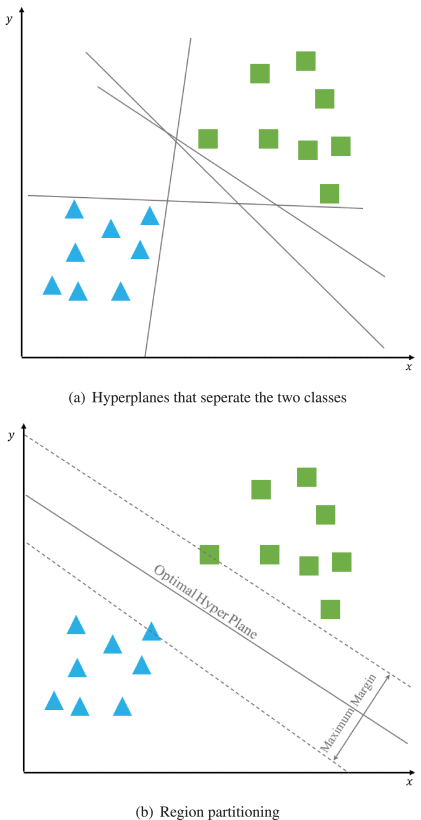

The task in this tutorial is binary classification. Given labeled data points belonging to 2 classes, we need to find a rule that can distinguish them.

$x \in R^{N \times D}$ - matrix with data points ,
$y \in R^N$ - vector of labels ,
$D$ - feature dimension ,
$N$ - number of data points

The way support vector machine, perceptron, and other linear models work is by creating a D-dimensional hyperplane that separates the points belonging to different classes.

First, let's generate some data and draw lines (2D hyperplanes) that separate it.

In [1]:
import numpy as np
from numpy.random import rand
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def get_data(all_points, separable=True):
  """
  :param all_pojnts: number of data points to be generated
  :param separable: boolean determining whether the generated data is linearly separable
  :return: a tuple (x, y):
  - x - numpy array of size (all_points, 2) with the data points
  - y - numpy array of size (all_points, ) with the data labels (1 or -1)
  """

  size = all_points // 2

  if separable:
    b1, b2 = 1.3, 0.7
  else:
    b1, b2 = 0.5, 0.3
  
  x0 = np.concatenate((rand(size), rand(size) + b1))
  x1 = np.concatenate((rand(size), rand(size) + b2))
  
  label = np.ones(all_points)
  label[:size] = -1
  return np.stack((x0, x1),axis=1), label

def get_random_line(magnitude=3):
  """
  Hesse normal form : x cos θ + y sin θ - p = 0
  where the line is orthogonal to a vector of length p and angle θ
  nice for generating random lines

  :param magnitude: scalar magnitude of largest random vector defining the line
  :return: a tuple (w, b):
  - w: a numpy array of size 2 with coefficients of the line
  - b: constant of the line
  """

  theta = rand() * 2 * np.pi
  w = np.array([np.cos(theta), np.sin(theta)])
  b = - rand() * magnitude
  return w, b

def lineary_separates_2D(x, y, w, b):
  """
  :return: boolean determining whether the line separates the data points correctly
  """
  pred = x.dot(w)+ b
  return np.all(( pred > 0 ) == ( y > 0))

def plot_data(x, y, margin=0.1):
  """
  Plots all the data points onto a graph
  
  :return: a tuple (x_min, x_max):
  - x_min: plot's minimum x coordinate value
  - x_max: plot's maximum x coordinate value
  """

  plot_dict = {'x0' : x[:,0], 'x1': x[:,1], 'label':y}
  sns.relplot(data=plot_dict, x='x0', y='x1', hue='label', 
            s=200, height=7, aspect=2, palette=sns.color_palette("dark",2) )
  x_min, x_max = min(plot_dict['x0']) - margin, max(plot_dict['x0']) + margin
  y_min, y_max = min(plot_dict['x1']) - margin, max(plot_dict['x1']) + margin
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  return x_min, x_max

def draw_line(w, b, x_min, x_max, color='green'):
  """
  Plots a line onto a graph in form:  w[0] * x + w[1] * y + b = 0

  :param w: a numpy array of size 2 with coefficients of the line
  :param b: constant of the line
  :param x_min: float determining the minimum x value for drawing
  :param x_max: float determining the maximum x value for drawing
  :param color: string determining color of the line
  """

  y_l = - (x_min * w[0] / w[1] + b / w[1])
  y_r = - (x_max * w[0] / w[1] + b / w[1])
  plt.plot((x_min, x_max), (y_l, y_r), linewidth=1, color=color)

In the code below, you can experiment with different random seed, the number of data points and lines to observe the space of possible solutions and how it depends on the distribution of data points.

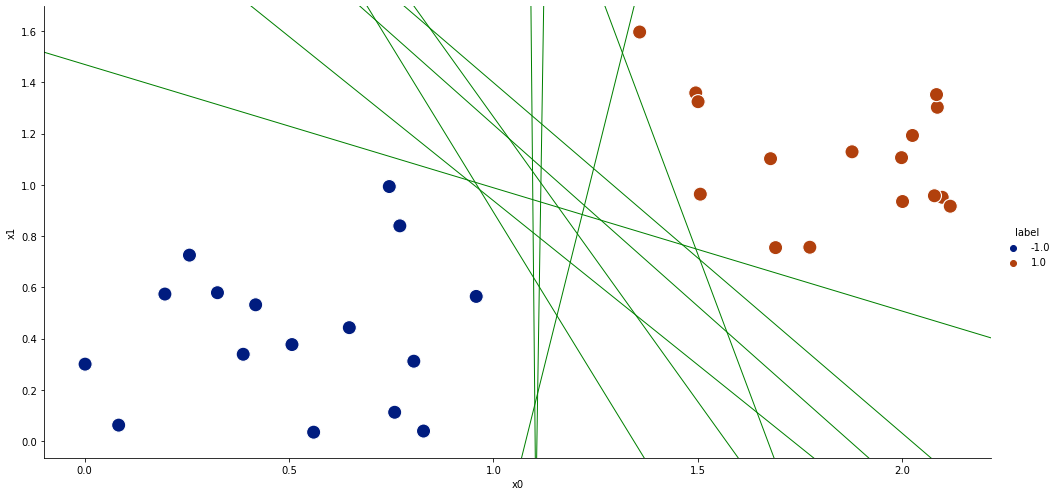

In [3]:
np.random.seed(1031)

x, y = get_data(all_points=32, separable=True)

x_min, x_max = plot_data(x, y)

# draw {n_lines} lines that seperate the data
n_lines = 10
for _ in range(n_lines):
  w, b = get_random_line()
  while not lineary_separates_2D(x, y, w, b):
    w, b = get_random_line()
  draw_line(w, b , x_min, x_max)

## Hyperplanes and margins

As seen in the example above if the data is linearly separable, there are usually a lot of different lines that partition it. Which one is the best?

Support Vector Machines (SVM) provides an answer to this question. Like perceptron, they are binary classification models defined by the hyperplane that separates the data. The hyperplane is defined by the equation:

\begin{equation}
xw-b=0
\end{equation}

where  $x\in R^{N \times D}, w \in R^D$, $b\in R$ and $D$ is dimension of the data.  Thus the main difference between perceptron and SVM is the way the weights (which define the hyperplane) are learned.

First, two additional parallel hyperplanes known as margins are defined:
\begin{equation}
xw-b=1
\end{equation}
\begin{equation}
xw-b=-1
\end{equation}

when $x_iw-b \geq 1$ clasify the point $y_i=1$,

when $x_iw-b \leq -1$ clasify the point $y_i=-1$

The objective is to find the hyperplane that separates the data with the largest distance between the margins. This version of SVM is called hard margin since the margins are not violated.

Run the next 2 cells to generate a hyperplane with margins. You can experiment with different random seed and the number of data points to observe how the solution depends on the distribution of data points. You can compare to the solutions in the previous cell.

In [4]:
# you don't need to understand this code, it is just used to generate random lines with valid margins

def get_random_direction():
  """
  :return: a numpy array of size (2,) with a vector of size 1 with random direction
  """

  theta = rand() * 2 * np.pi
  return np.array([np.cos(theta), np.sin(theta)])

def direction_lineary_separates_2D(x, y, w):
  """
  :return: boolean determining whether there exists a line with direction determined 
  by w which separates the data points correctly
  """
  projected = x.dot(w)
  l = np.max( projected[ y == -1 ] )
  r = np.min( projected[ y ==  1 ] )
  return l < r

def find_line_with_margins(x, y, w):
  """
  Find a line with direction determined by w that has the largest margins
  """

  projected = x.dot(w)
  l = np.max( projected[ y == -1 ] )
  r = np.min( projected[ y ==  1 ] )
  b = - (l + r) / 2
  scale = 2 / (l - r)
  return w * scale, b * scale

def draw_line_with_margin(w, b, x_min, x_max):
  """
  Draw the line determined by w and b with margins
  """

  draw_line(w, b  , x_min, x_max)
  draw_line(w, b-1, x_min, x_max, color='red')
  draw_line(w, b+1, x_min, x_max, color='red')

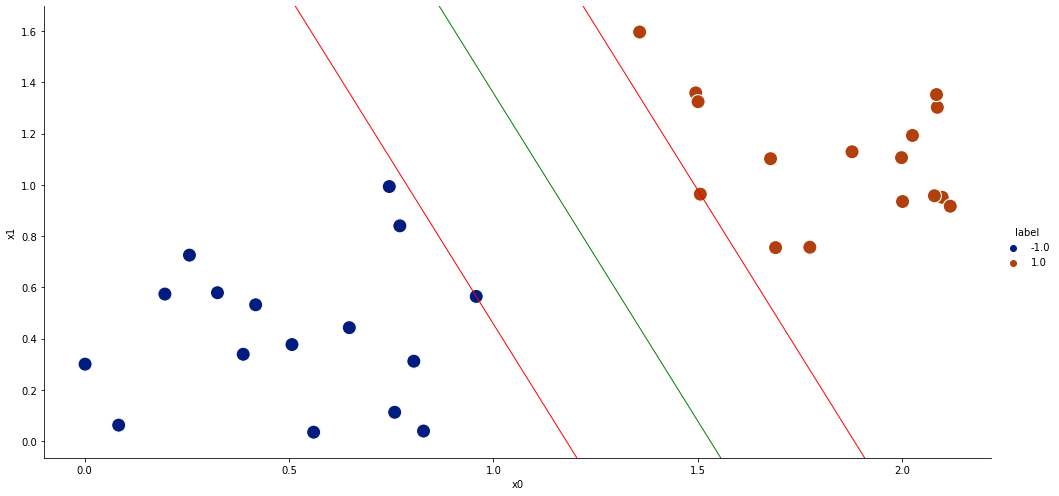

In [5]:
np.random.seed(1031)

x, y = get_data(all_points=32)

# find a valid line
w = get_random_direction()
while not direction_lineary_separates_2D(x, y, w):
    w = get_random_direction()
w, b = find_line_with_margins(x, y, w)

# plot all
x_min, x_max = plot_data(x, y)
draw_line_with_margin(w, b, x_min, x_max)

Thus besides the main hyperplane (green line), we get 2 additional ones which are called margins (red lines). All the points belonging to the -1 class lay below the left margin, while all the ones that belong to 1 class lay above the right one.

Notice that 2 data points lay directly on the margins. These 2 points have a special name: support vectors, which limit the size of the margin.

Side note:

How can a hyperplane define margins as well?

We define hyperplane using $D+1$ paramters for $w$ and $b$. However, it can be defined using only $D$ parameters.

For instance in 2D the line:

\begin{equation}
w_0 x_0 + w_1 x_1 + b = 0
\end{equation}
defines exactly the same line as
\begin{equation}
\frac{w_0}{2} x_0 + \frac{w_1}{2} x_1 + \frac{b}{2}  = 0
\end{equation}

Thus, our paremteres overdeifne the hyperplane and the one free dimension defines the margins.

## Task 1:

Find the margins size of a hyperplane defined  by $w$ and $b$ from the previous example. Show your code (including equation(s)) you used along with the result in your report.

In [6]:
print("support vector point 1: ", x[5])
print("support vector point 2: ", x[17])

# find ||w||
w1 = np.linalg.norm(w)
w_direction = [w[0]/w1, w[1]/w1, b/w1]

p_scale = x[17][0]*w_direction[0] + x[17][1]*w_direction[1] + w_direction[2]

projection = [w_direction[0]*p_scale, w_direction[1]*p_scale, w_direction[2]*p_scale]

# margin size is 2||p||
size = 2*np.linalg.norm(projection[:2])

# straight forward way
size_ = 2/np.linalg.norm(w)

print(size)
print(size_)

support vector point 1:  [0.95773912 0.5644673 ]
support vector point 2:  [1.50588589 0.96349216]
0.6557531153622742
0.6557531153622747


## Hard Margin SVM Optimisation

In optimization form the problem is:

\begin{equation}
argmax_{w,b} \frac{const}{|w|}
\end{equation}

such that

\begin{equation}
w^Tx_i+ b >  1 \text{ when  } y_i =  1
\end{equation}
\begin{equation}
w^Tx_i+ b < -1 \text{  when  } y_i = -1
\end{equation}

This formulation can be simplified by noticing that maximizing $\frac{const}{|w|}$ is equivalent to minimizing $|w|$. Additionally, the constraints can be rewritten as $y_i(w^Tx_i+ b)>1$. Thus, the problem can be rewritten as:
\begin{equation}
argmin_{w,b} |w|
\end{equation}

such that:
\begin{equation}
y_i(w^Tx_i+ b)>1
\end{equation}

*Optimisation Sidenote:*
This is a convex minimization problem since $f(x)=|x|$ is a convex function and the constraints are linear. This means that we can find the global solution using gradient descent algorithms accounting for the inequality constraints. In practice, the solution can be found more effectively using Lagrangian dual of the problem.

## Softmargin SVM

What if the data is not linearly separable?

We can relax the constraints to allow for some data points to violate the margin. Recall the constrain equation generated by data point $i$:
\begin{equation}
y_i(x_iw+ b)>1
\end{equation}

Thus, we should penalize the $w,b$ selection if it is violated.
\begin{equation}
cost_i = max(0, 1-y_i(x_iw + b))
\end{equation}

You can verify that if the point lays on the correct side of the margin the cost is 0, and if it is on the other one the cost is equal to the distance to the margin.

The revised optimisation problem is:
\begin{equation}
argmin_{w,b}{Loss}(w,b) = argmin_{w,b}|w| + \lambda \frac{1}{N} \sum_{i\in\{1,..,N\}}{cost_i}
\end{equation}

or 

\begin{equation}
argmin_{w,b}|w| + \lambda \frac{1}{N} \sum_{i\in\{1,..,N\}}{max(0, 1-y_i(x_iw + b))}
\end{equation}

where $\lambda$ is a hyperparamter. The larger it is, the more importance is given to the second term of the loss and the more the solution resembles the hard margin SVM.

Since, this is an unconstrained optimization problem we can solve it using gradient descent. The gradient of the function is

\begin{equation}
\nabla_w {Loss}(w,b) = \frac{w}{|w|} - \lambda \frac{1}{N} \sum_{i\in\{1,..,N\}}{\mathbb{u}(1-y_i(x_iw+ b)) y_i x_i}
\end{equation}

\begin{equation}
\nabla_b {Loss}(w,b) = - \lambda \frac{1}{N} \sum_{i\in\{1,..,N\}}{\mathbb{u}(1-y_i(x_iw+ b)) y_i}
\end{equation}

where $\mathbb{u}$ is a step function:

\begin{equation}
\mathbb{u}(x) = 
\begin{cases}
1 & \text{if} & x \ge 0 \\
0 & \text{if} & x \lt 0
\end{cases}
\end{equation}




## Task 2:

Implement a function that calculates the loss given $w$, $b$, $\lambda$ and the data $x$, $y$. Show the code and results in your report.

In [49]:
from math import sqrt

def modulus(x):
  if len(x) != 2:
    raise Exception(f"Expecting length of x to be x, got length {len(x)} instead.")

  return sqrt(x[0]**2 + x[1]**2)

def loss(w, b, lam, x, y):
  """
  Calculates loss of the SVM defined by w and b, given the data x, y

  :param w: a numpy array of size 2 with coefficients of the line
  :param b: scalar, the constant of the line
  :param lam: scalar hyperparameter of SVN
  :param x: numpy array of size (N, 2) with the data points
  :param y: numpy array of size (B, ) with the data labels (1 or -1)

  :return: scalar the Loss 
  """

  summing = 0

  for i in range(len(y)):
    xw = x[i][0]*w[0] + x[i][1]*w[1]
    cost = max(0, 1 - y[i] * (np.dot(x[i], w) + b))

    summing += cost

  return modulus(w) + (lam / len(y)) * summing
  

## Task 3:

Implement a function that calulates the gradient of Loss with respect to $w$ and $b$. Show the code and results in your report.

In [8]:
from typing import Tuple

def get_grad_w(w, b, lam, x, y) -> np.array:
  summing = np.array([0, 0])
  for i in range(len(y)):
    xw = x[i][0]*w[0] + x[i][1]*w[1]
    u_value = 1 - y[i]*(xw + b)

    if u_value >= 0:
      ux = np.array([y[i] * val for val in x[i]])
    else:
      ux = np.array([0, 0])

    summing[0] += ux[0]
    summing[1] += ux[1]

  weight_modulus = np.linalg.norm(w)
  weights = [weight / weight_modulus for weight in w]

  second_term = - lam * (1/len(y)) * summing

  return np.array([weights[0] + second_term[0], weights[1] + second_term[1]])

def get_grad_b(w, b, lam, x, y) -> float:
  summing = 0
  for i in range(len(y)):
    xw = x[i][0]*w[0] + x[i][1]*w[1]
    u_value = 1 - y[i]*(xw + b)

    if u_value >= 0:
      ux = y[i]
    else:
      ux = 0

    summing += ux

  return -1 * lam * (1/len(y)) * summing

def gradient(w, b, lam, x, y) -> Tuple[np.array, float]:
  """
  Calculates loss of the SVM defined by w and b, given the data x, y

  :param w: a numpy array of size (2,) with coefficients of the line
  :param b: scalar, the constant of the line
  :param lam: scalar hyperparameter of SVN
  :param x: numpy array of size (N, 2) with the data points
  :param y: numpy array of size (B,) with the data labels (1 or -1)

  :return: a tuple (grad_w, grad_b) 
  - grad_w: a numpy array of size (2,) with the gradient of w w.r.t. Loss
  - grad_b: a scalar of the gradient of b w.r.t. Loss
  """

  return get_grad_w(w, b, lam, x, y), get_grad_b(w, b, lam, x, y)

In [35]:
def get_alpha(w, b, grad_w, grad_b, lam, x, y):
  """
  :return: a scalar that determines the size of the step for optimisation
  """
  alpha = 1
  
  loss_val = loss(w, b, lam, x, y)
  for i in range(50):
    w_new = w - [alpha * grad_w[0], alpha * grad_w[1]]
    
    b_new = b - alpha * grad_b
    
    loss_new = loss(w_new, b_new, lam, x, y)
    if loss_new <= loss_val: # - alpha * 0.5 * (grad_w.dot(grad_w) + grad_b ** 2):
      return alpha    
    alpha = alpha / 1.2
  
  return 0

In [10]:
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib import font_manager as fm, pyplot as plt

!wget https://github.com/trishume/OpenTuringCompiler/blob/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf
!wget https://github.com/matomo-org/travis-scripts/blob/master/fonts/Arial.ttf 

font_files = fm.findSystemFonts()

# Go through and add each to Matplotlib's font cache.
for font_file in font_files:
    fm.fontManager.addfont(font_file)

fm.fontManager.ttflist += fm.createFontList(['Times New Roman.ttf'])

# Use your new font on all your plots.
plt.rc('font', family='serif')

--2022-11-24 00:45:01--  https://github.com/trishume/OpenTuringCompiler/blob/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Times New Roman.ttf.1’

Times New Roman.ttf     [ <=>                ] 138.45K  --.-KB/s    in 0.07s   

2022-11-24 00:45:02 (1.84 MB/s) - ‘Times New Roman.ttf.1’ saved [141775]

--2022-11-24 00:45:02--  https://github.com/matomo-org/travis-scripts/blob/master/fonts/Arial.ttf
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Arial.ttf.1’

Arial.ttf.1             [ <=>                ] 134.99K  --.-KB/s    in 0.07s   

2022-11-24 00:45:02 (1.77 MB/s) - ‘Arial.ttf.1’ saved [138231]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  


step : 100 , Loss : 80.67377715115984
i : 145


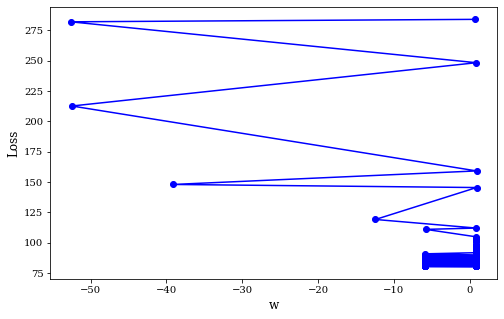

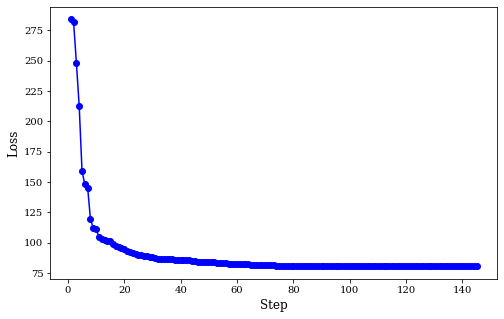

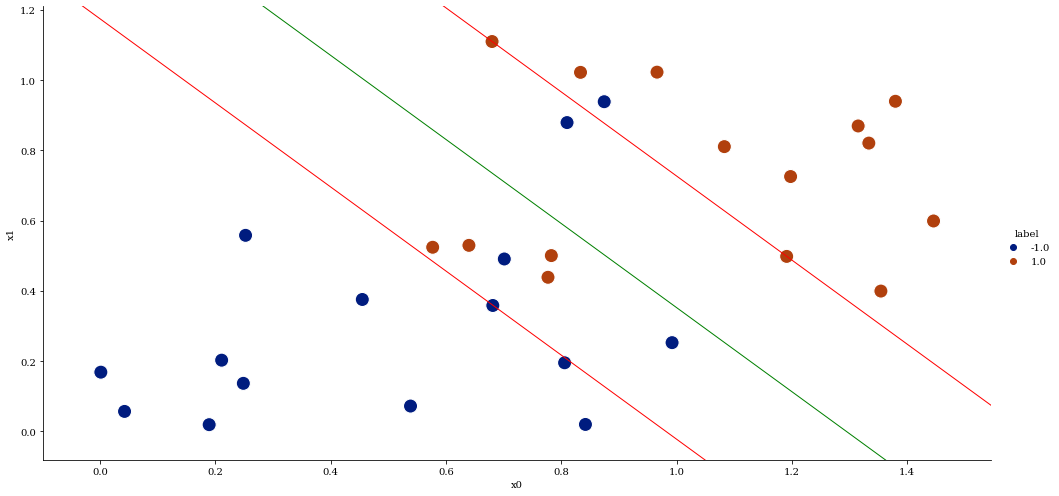

In [50]:
def draw_line_final(lam = 200):
  np.random.seed(1034)
  x, y = get_data(all_points=30, separable=False)
  w = np.ones((2,))
  b = 1
  w_store = []
  b_store =[]

  N_iter = 1000
  lossplt=[]
  for i in range(1, N_iter):
    loss_val = loss(w, b, lam, x, y)
    lossplt.append(loss_val)
    if i % (N_iter // 10) == 0:
      print("step : {:3} , Loss : {}".format(i, loss_val))

    grad_w, grad_b = gradient(w, b, lam, x, y)
    alpha = get_alpha(w, b, grad_w, grad_b, lam, x, y)
    w -= grad_w * alpha
    b -= grad_b * alpha
    w_store.append(grad_w[0])
    b_store.append(grad_b)
    
    if alpha == 0:
      print("i : {}".format(i))
      break
  
  plt.figure(figsize=(8, 5))
  plt.plot(w_store, lossplt, marker='o', color='blue')
  plt.ylabel('Loss', size=12)
  plt.xlabel('w', size=12)
  
  plt.figure(figsize=(8, 5))
  plt.plot(np.linspace(1,len(lossplt),len(lossplt)), lossplt, marker='o', color='blue')
  plt.ylabel('Loss', size=12)
  plt.xlabel('Step', size=12)
  x_min, x_max = plot_data(x, y)
  draw_line_with_margin(w, b, x_min, x_max)

draw_line_final()


## Task 4:

Try different hyperparameters lambda with separable and non-separable data. Try lambda ranging from 2 to 200.

Write your observations (around 30 words).

i : 36


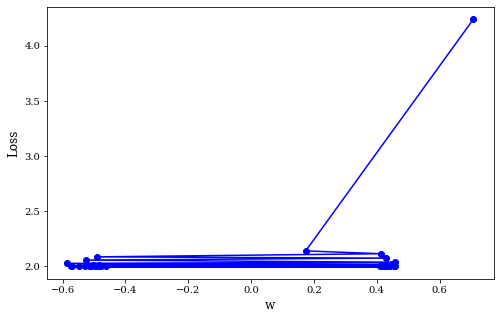

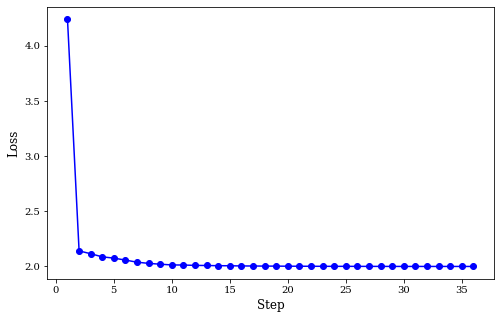

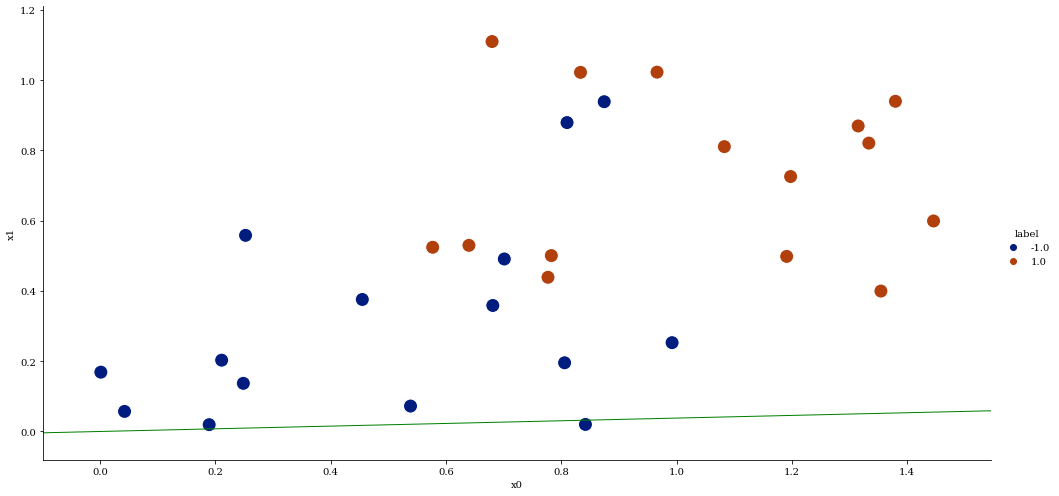

In [44]:
draw_line_final(lam = 2)

i : 57


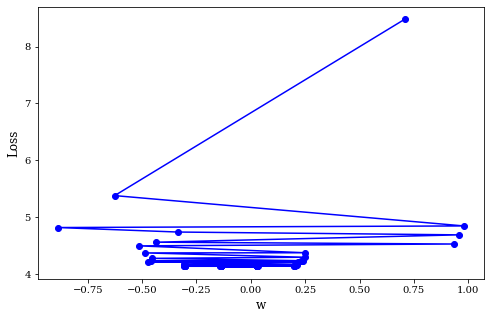

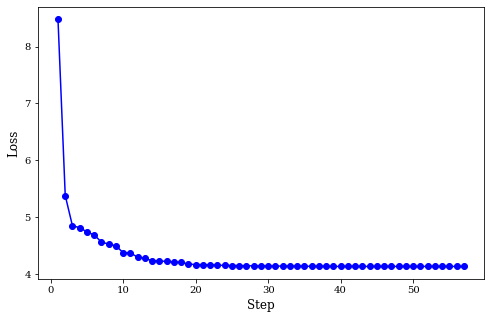

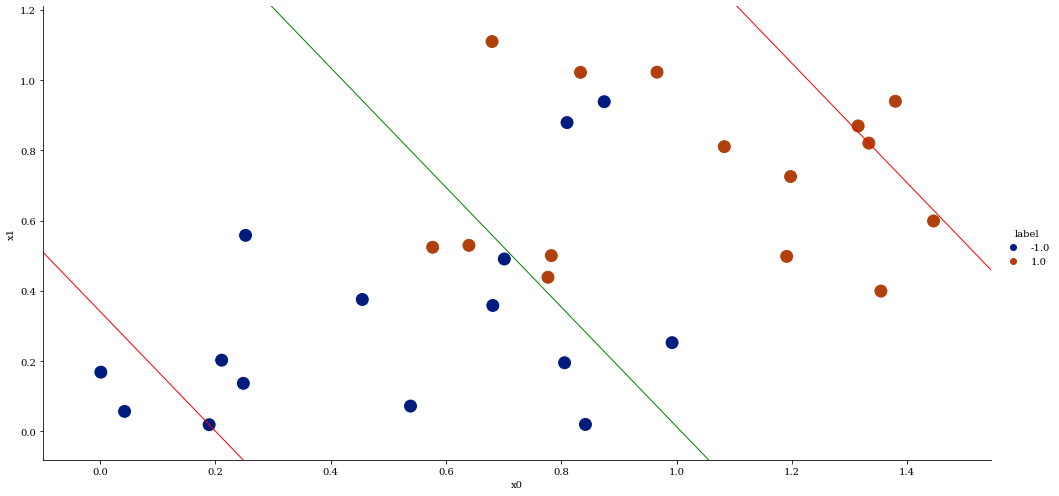

In [45]:
draw_line_final(lam = 5)

i : 23


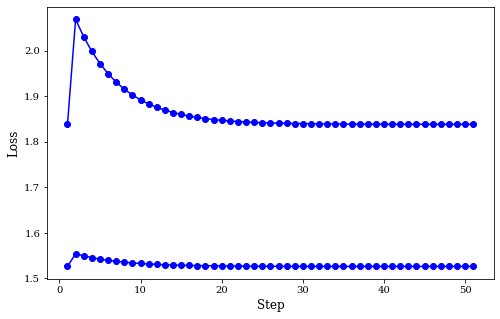

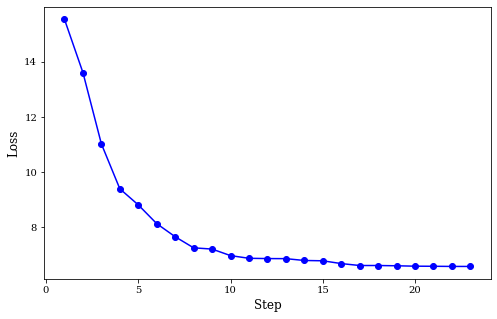

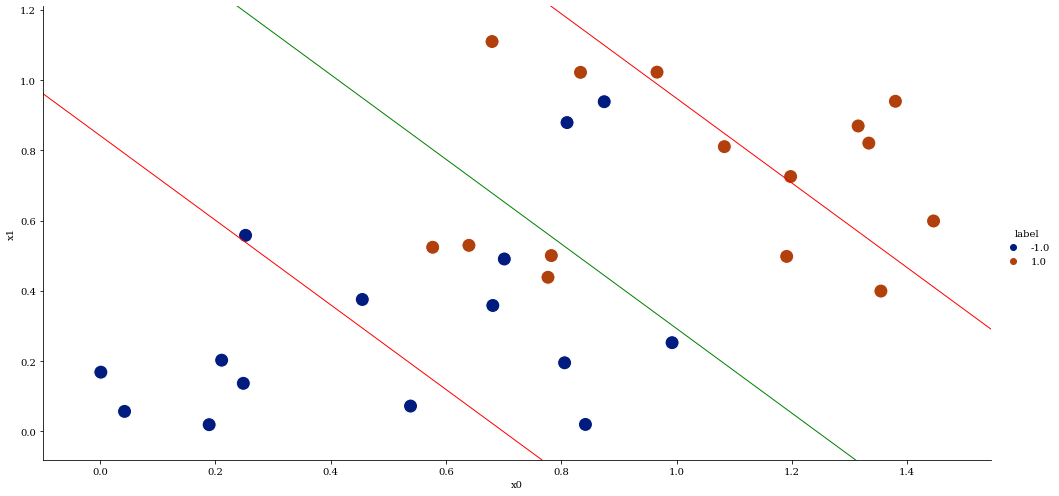

In [14]:
draw_line_final(lam = 10)

i : 60


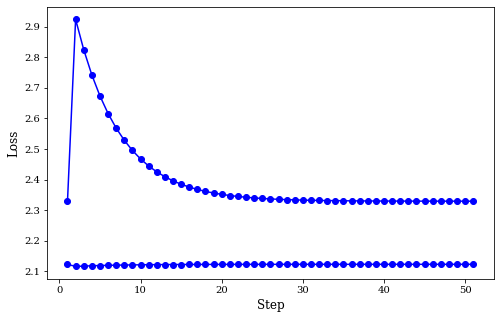

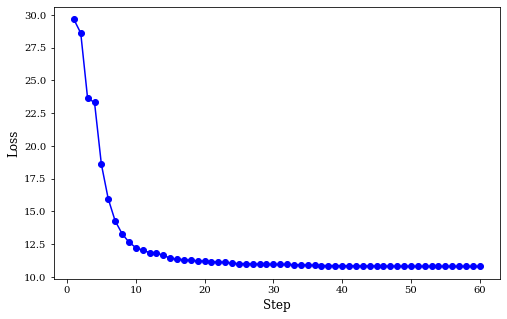

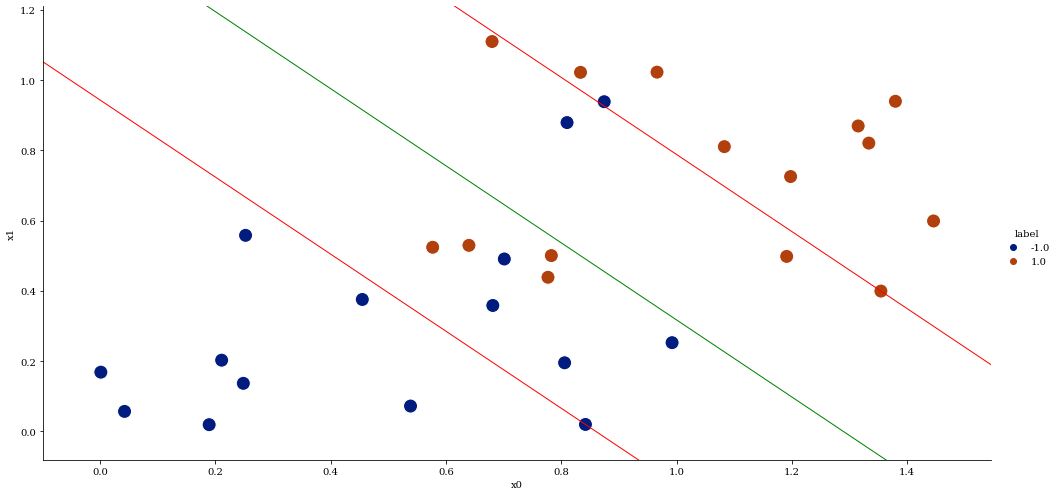

In [15]:
draw_line_final(lam = 20)

i : 82


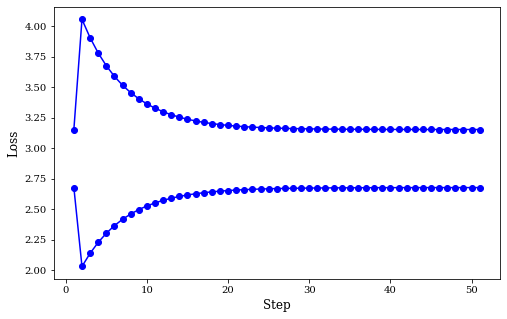

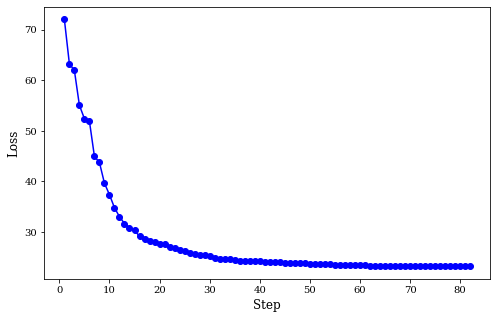

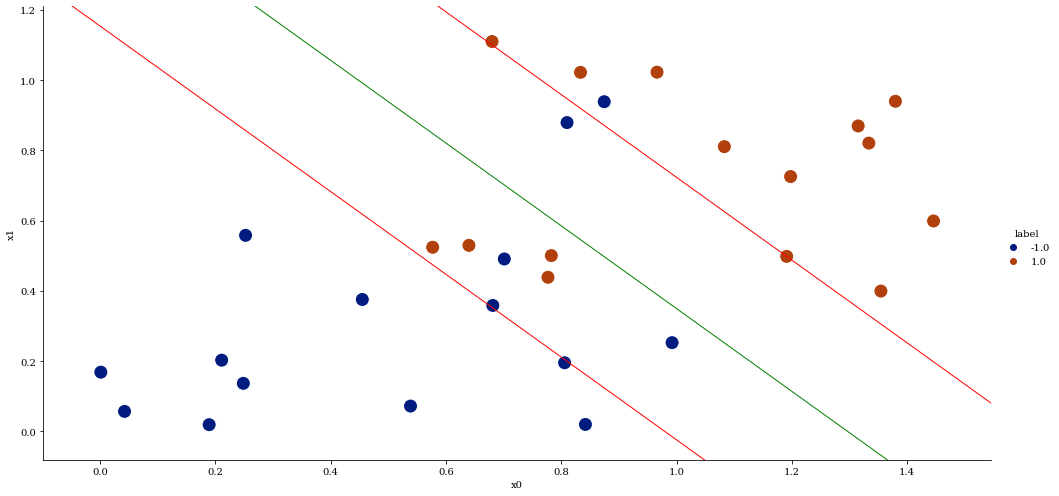

In [16]:
draw_line_final(lam = 50)

step : 100 , Loss : 42.324958219972814
i : 132


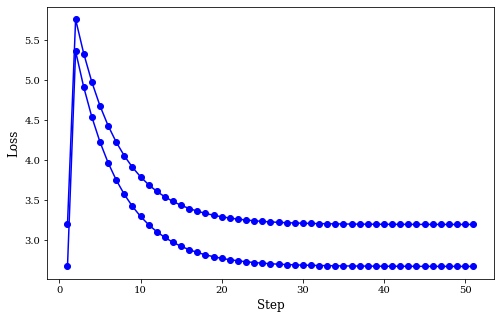

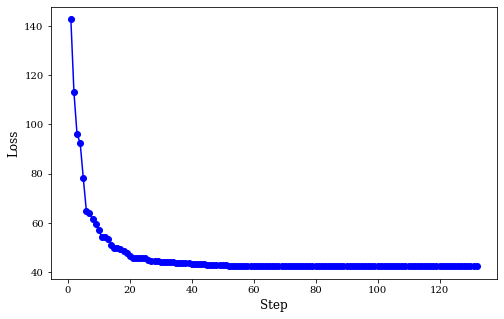

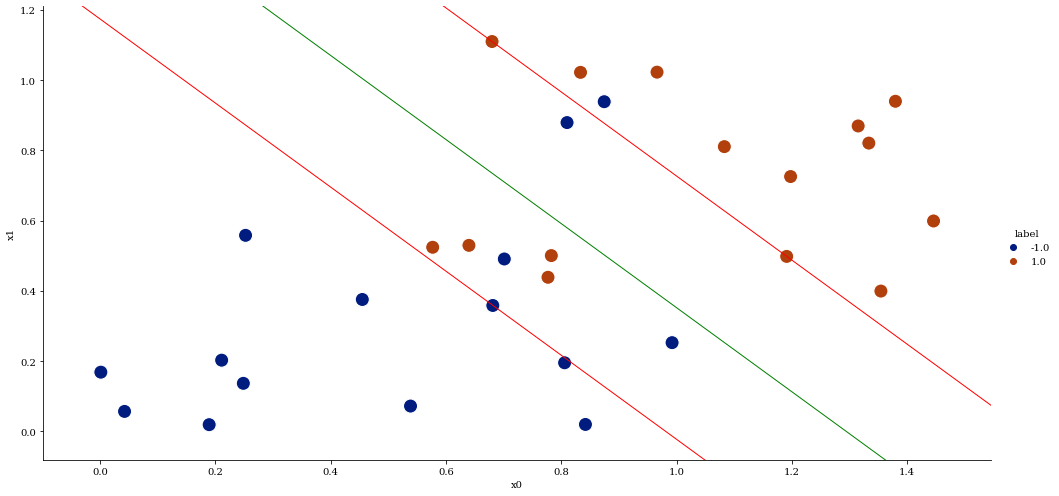

In [17]:
draw_line_final(lam = 100)

step : 100 , Loss : 61.35578681445938
i : 101


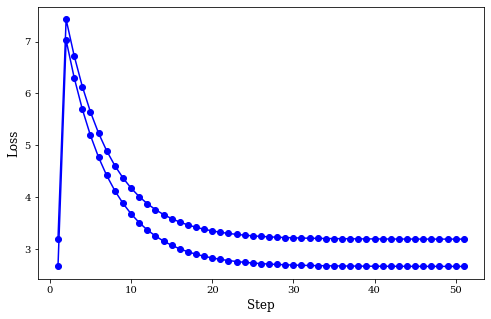

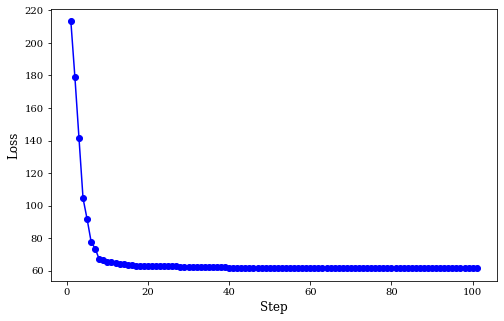

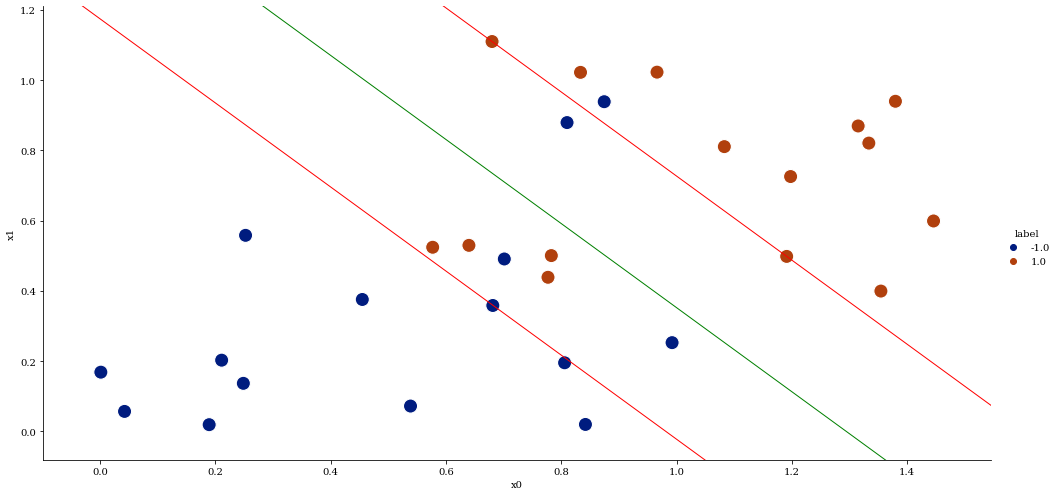

In [18]:
draw_line_final(lam = 150)

In [58]:
def draw_line_separable(lam = 200):
  np.random.seed(1031)
  x, y = get_data(all_points=32, separable=True)
  w = np.ones((2,))
  b = 1
  lossplt=[]
  N_iter = 1000
  for i in range(1, N_iter):
    loss_val = loss(w, b, lam, x, y)
    lossplt.append(loss_val)
    if i % (N_iter // 10) == 0:
      print("step : {:3} , Loss : {}".format(i, loss_val))

    grad_w, grad_b = gradient(w, b, lam, x, y)
    alpha = get_alpha(w, b, grad_w, grad_b, lam, x, y)
    w -= grad_w * alpha
    b -= grad_b * alpha
    
    if alpha == 0:
      print("i : {}".format(i))
      print( 2/np.linalg.norm(w))
      break
  
  plt.figure(figsize=(8, 5))
  plt.plot(np.linspace(1,len(lossplt),len(lossplt)), lossplt, marker='o', color='blue')
  plt.ylabel('Loss', size=12)
  plt.xlabel('Step', size=12)
  x_min, x_max = plot_data(x, y)
  draw_line_with_margin(w, b, x_min, x_max)

i : 39
1.8054365893176076


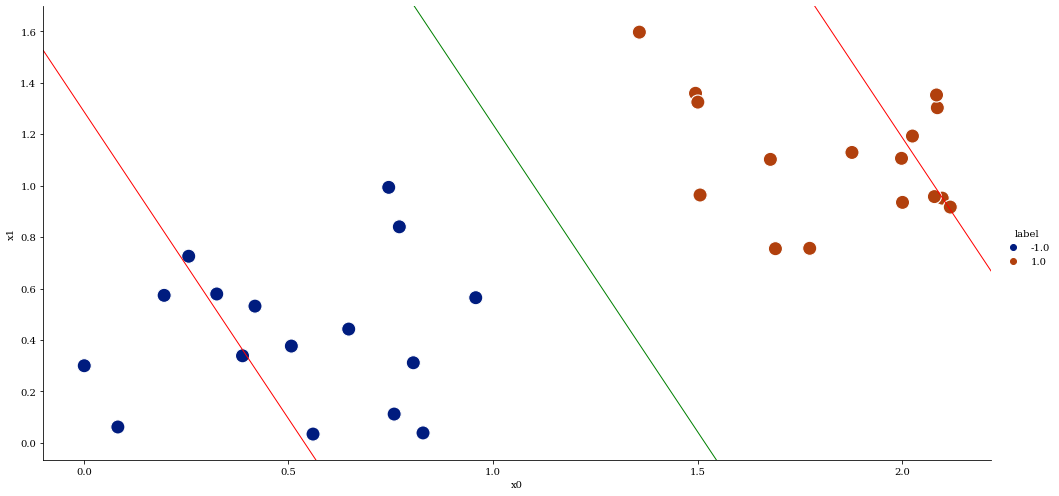

In [52]:
draw_line_separable(2)

i : 16
1.210069656401686


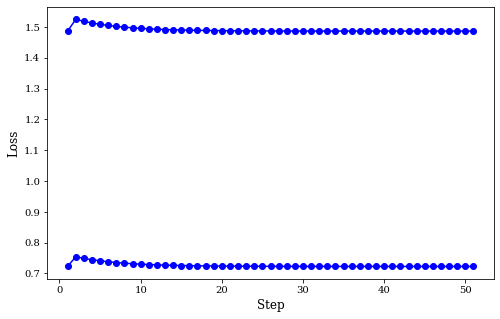

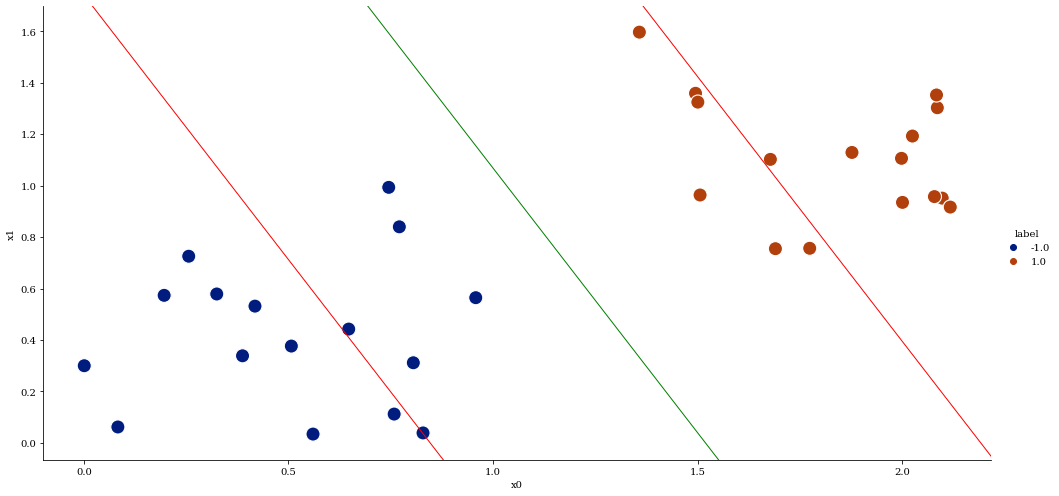

In [21]:
draw_line_separable(5)

i : 45
0.8603442745754368


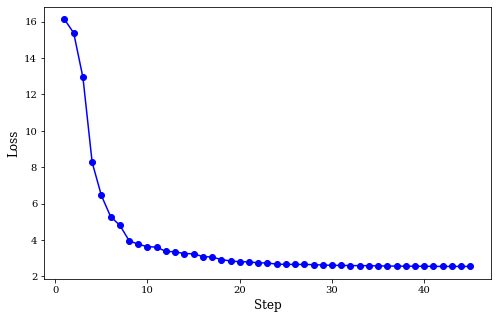

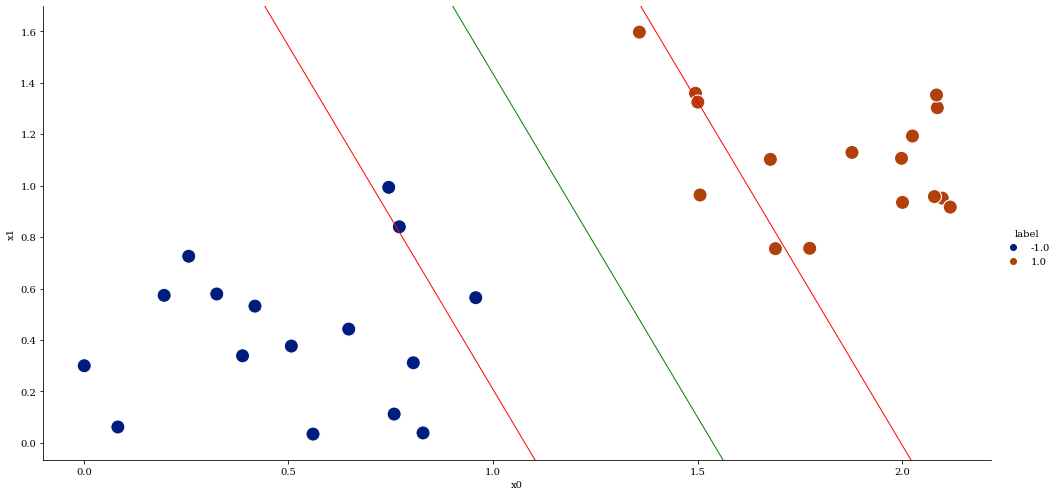

In [59]:
draw_line_separable(10)

step : 100 , Loss : 2.7960317947477376
i : 114
0.7714041436455414


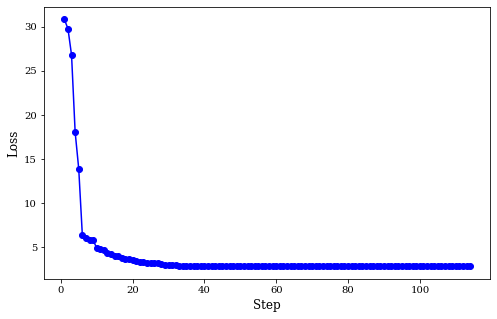

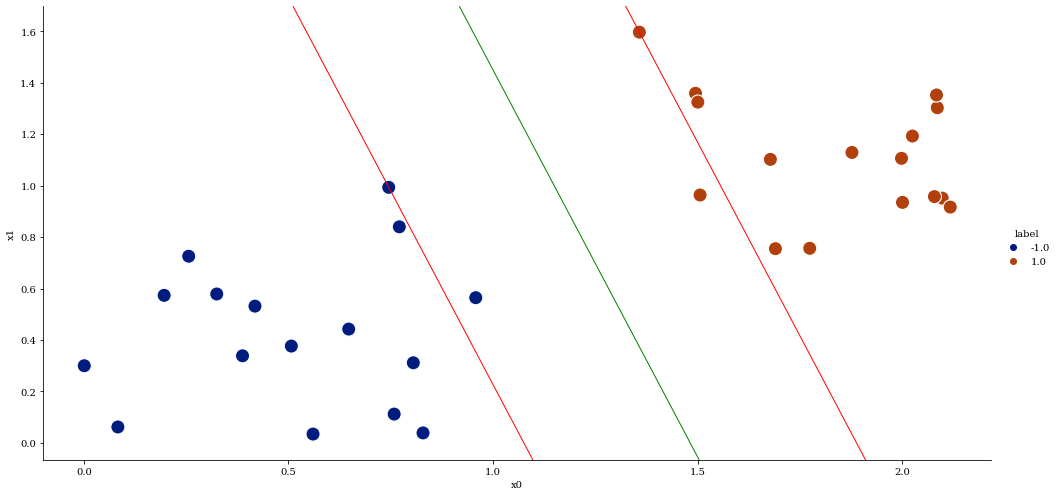

In [60]:
draw_line_separable(20)

step : 100 , Loss : 3.2044637770563877
i : 114
0.6247205299299012


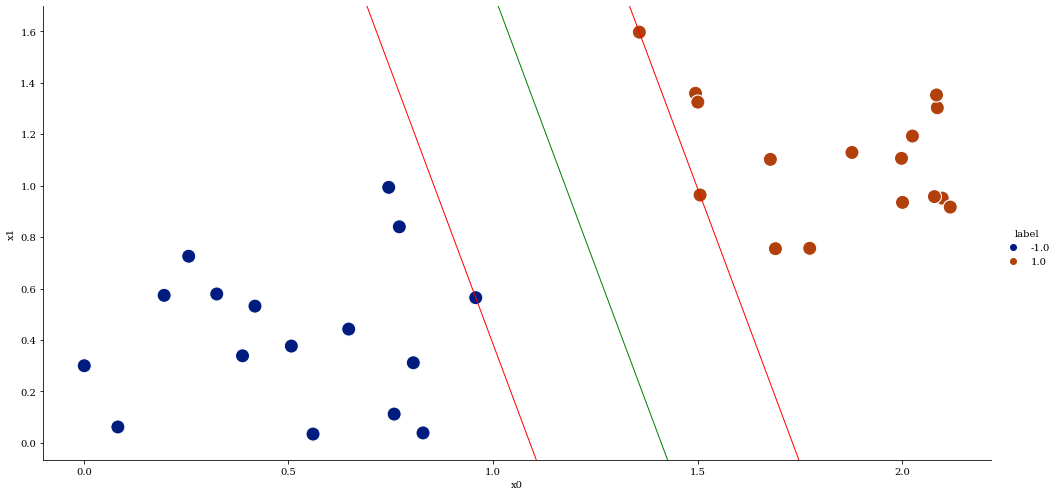

In [53]:
draw_line_separable(50)

i : 49
0.19181203091779622


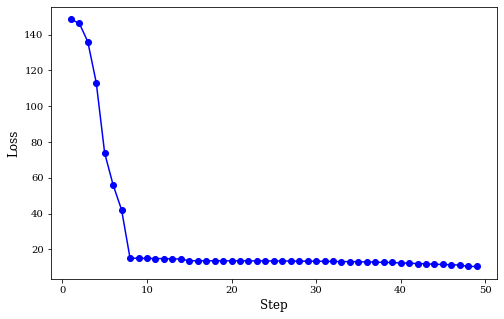

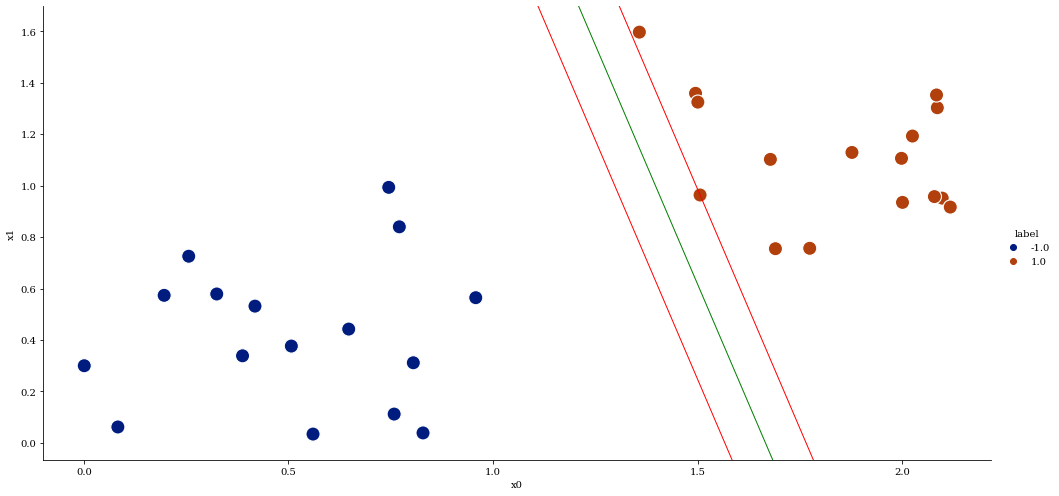

In [62]:
draw_line_separable(100)

i : 18
0.23371468302389056


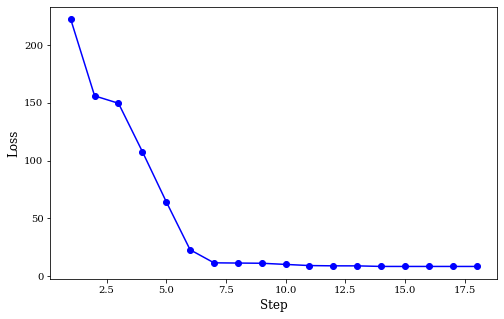

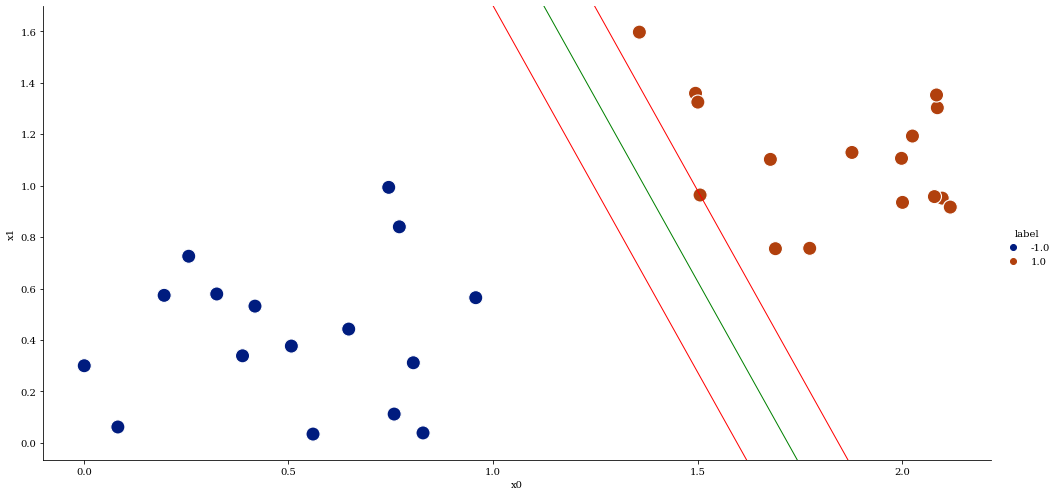

In [65]:
draw_line_separable(150)

i : 23
0.13337985024274435


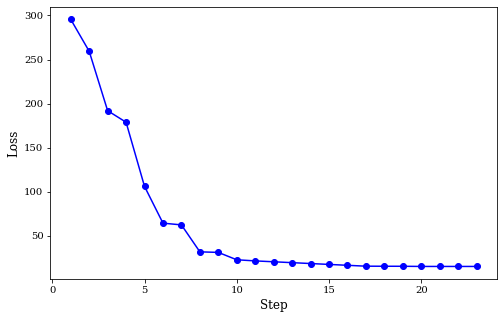

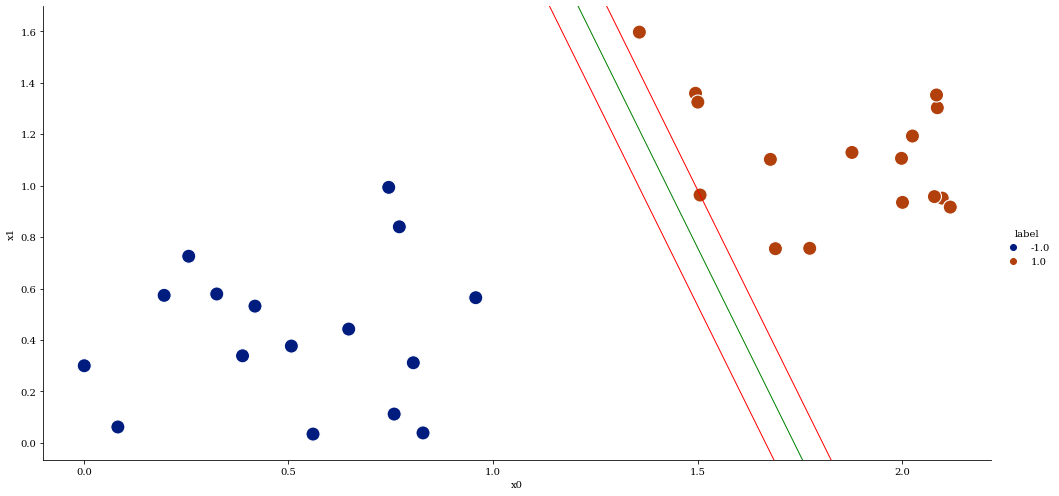

In [67]:
draw_line_separable(200)